# 02 - Data Loading & EDA con COCO Dataset
## Análisis exploratorio y preparación de datos

In [2]:
from ultralytics import YOLO
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import cv2
from PIL import Image

sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# Paths
BASE_DIR = Path("./product_recognition")
DATASETS_DIR = BASE_DIR / "datasets"
COCO_DIR = DATASETS_DIR / "coco"

## Descargar COCO Dataset (subset para demo)

In [4]:
# YOLO tiene integración con COCO
# Vamos a usar COCO128 (128 imágenes) para pruebas rápidas

import urllib.request
import zipfile

COCO128_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip"
zip_path = DATASETS_DIR / "coco128.zip"

if not COCO_DIR.exists():
    print("Descargando COCO128...")
    urllib.request.urlretrieve(COCO128_URL, zip_path)
    
    print("Extrayendo...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATASETS_DIR)
    
    # Renombrar
    (DATASETS_DIR / "coco128").rename(COCO_DIR)
    zip_path.unlink()
    print(f"✓ Dataset descargado en: {COCO_DIR}")
else:
    print(f"✓ Dataset ya existe en: {COCO_DIR}")

Descargando COCO128...
Extrayendo...
✓ Dataset descargado en: product_recognition/datasets/coco


## Crear configuración YAML para YOLO

In [5]:
# YOLO necesita un archivo YAML con la configuración del dataset
coco_yaml_config = {
    'path': str(COCO_DIR.absolute()),
    'train': 'images/train2017',
    'val': 'images/train2017',  # Usando train para demo
    'test': '',
    'names': {
        0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
        5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
        10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
        14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
        20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
        25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
        30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat',
        35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket',
        39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife',
        44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich',
        49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza',
        54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',
        59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop',
        64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
        69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book',
        74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier',
        79: 'toothbrush'
    }
}

yaml_path = COCO_DIR / "coco128.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(coco_yaml_config, f, default_flow_style=False)

print(f"✓ Config YAML creado: {yaml_path}")
print(f"Total clases: {len(coco_yaml_config['names'])}")

✓ Config YAML creado: product_recognition/datasets/coco/coco128.yaml
Total clases: 80


## EDA: Análisis del Dataset

In [6]:
# Listar imágenes y labels
images_dir = COCO_DIR / "images" / "train2017"
labels_dir = COCO_DIR / "labels" / "train2017"

image_files = list(images_dir.glob("*.jpg"))
label_files = list(labels_dir.glob("*.txt"))

print(f"Total imágenes: {len(image_files)}")
print(f"Total labels: {len(label_files)}")

Total imágenes: 128
Total labels: 128


In [7]:
# Analizar distribución de clases
all_classes = []
bbox_counts_per_image = []

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        bbox_counts_per_image.append(len(lines))
        for line in lines:
            class_id = int(line.split()[0])
            all_classes.append(class_id)

class_counts = Counter(all_classes)
print(f"\nTotal bounding boxes: {len(all_classes)}")
print(f"Clases únicas detectadas: {len(class_counts)}")


Total bounding boxes: 941
Clases únicas detectadas: 71


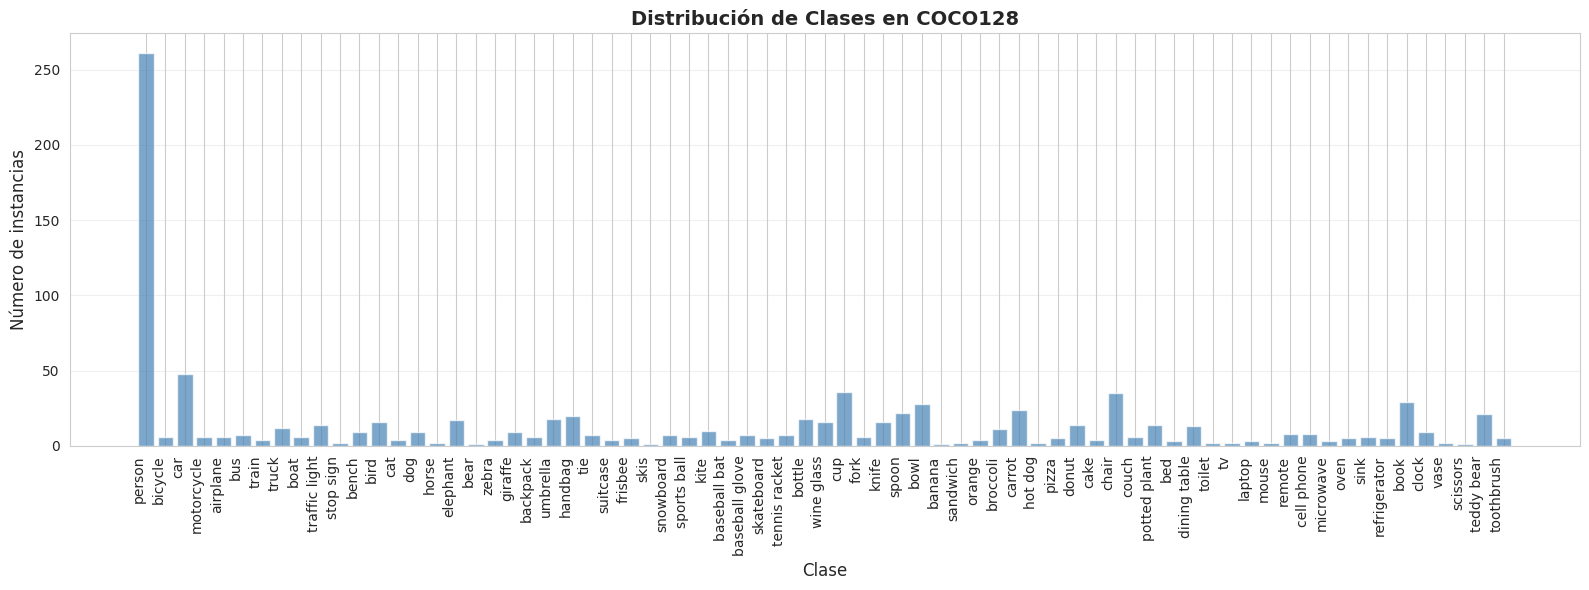


Top 10 clases más frecuentes:
  person              : 261 instancias
  car                 :  48 instancias
  cup                 :  36 instancias
  chair               :  35 instancias
  book                :  29 instancias
  bowl                :  28 instancias
  carrot              :  24 instancias
  spoon               :  22 instancias
  teddy bear          :  21 instancias
  handbag             :  20 instancias


In [8]:
# Visualización: Distribución de clases
class_names = [coco_yaml_config['names'][i] for i in sorted(class_counts.keys())]
class_values = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(16, 6))
plt.bar(range(len(class_values)), class_values, color='steelblue', alpha=0.7)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de instancias', fontsize=12)
plt.title('Distribución de Clases en COCO128', fontsize=14, fontweight='bold')
plt.xticks(range(len(class_names)), class_names, rotation=90, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Top 10 clases más frecuentes
top_10 = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 clases más frecuentes:")
for cls_id, count in top_10:
    print(f"  {coco_yaml_config['names'][cls_id]:20s}: {count:3d} instancias")

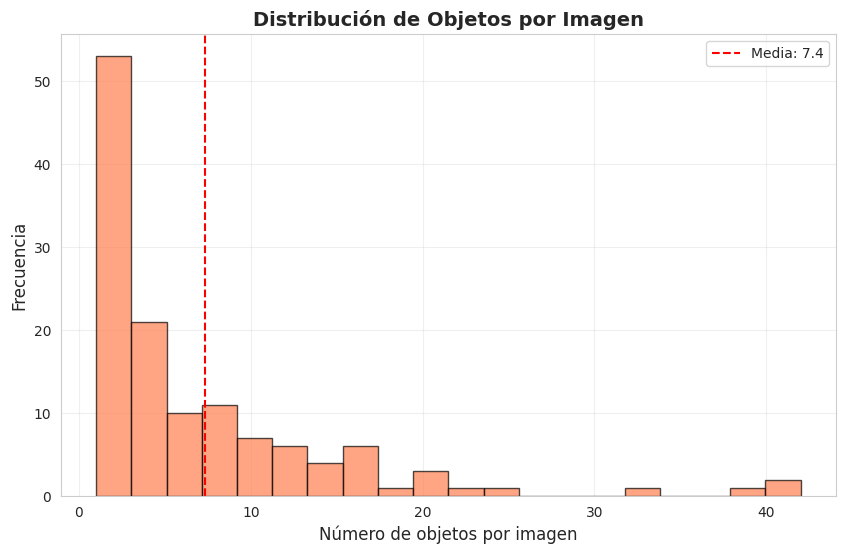


Estadísticas de objetos por imagen:
  Media: 7.35
  Mediana: 4.00
  Mínimo: 1
  Máximo: 42


In [9]:
# Visualización: Bounding boxes por imagen
plt.figure(figsize=(10, 6))
plt.hist(bbox_counts_per_image, bins=20, color='coral', alpha=0.7, edgecolor='black')
plt.xlabel('Número de objetos por imagen', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Objetos por Imagen', fontsize=14, fontweight='bold')
plt.axvline(np.mean(bbox_counts_per_image), color='red', linestyle='--', 
            label=f'Media: {np.mean(bbox_counts_per_image):.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\nEstadísticas de objetos por imagen:")
print(f"  Media: {np.mean(bbox_counts_per_image):.2f}")
print(f"  Mediana: {np.median(bbox_counts_per_image):.2f}")
print(f"  Mínimo: {np.min(bbox_counts_per_image)}")
print(f"  Máximo: {np.max(bbox_counts_per_image)}")

## Detectar clases desbalanceadas

In [10]:
# Análisis de desbalance
total_instances = sum(class_counts.values())
class_percentages = {cls: (count/total_instances)*100 
                     for cls, count in class_counts.items()}

# Clases con menos del 1% de representación
underrepresented = [(cls, pct) for cls, pct in class_percentages.items() if pct < 1.0]
underrepresented.sort(key=lambda x: x[1])

print("\n⚠️  Clases sub-representadas (<1%):")
for cls_id, pct in underrepresented:
    print(f"  {coco_yaml_config['names'][cls_id]:20s}: {pct:.2f}% ({class_counts[cls_id]} instancias)")

print(f"\nTotal clases desbalanceadas: {len(underrepresented)}/{len(class_counts)}")


⚠️  Clases sub-representadas (<1%):
  scissors            : 0.11% (1 instancias)
  skis                : 0.11% (1 instancias)
  bear                : 0.11% (1 instancias)
  banana              : 0.11% (1 instancias)
  vase                : 0.21% (2 instancias)
  toilet              : 0.21% (2 instancias)
  stop sign           : 0.21% (2 instancias)
  sandwich            : 0.21% (2 instancias)
  tv                  : 0.21% (2 instancias)
  mouse               : 0.21% (2 instancias)
  hot dog             : 0.21% (2 instancias)
  horse               : 0.21% (2 instancias)
  bed                 : 0.32% (3 instancias)
  microwave           : 0.32% (3 instancias)
  laptop              : 0.32% (3 instancias)
  orange              : 0.43% (4 instancias)
  baseball bat        : 0.43% (4 instancias)
  cat                 : 0.43% (4 instancias)
  train               : 0.43% (4 instancias)
  zebra               : 0.43% (4 instancias)
  cake                : 0.43% (4 instancias)
  suitcase        

## Visualizar muestras del dataset

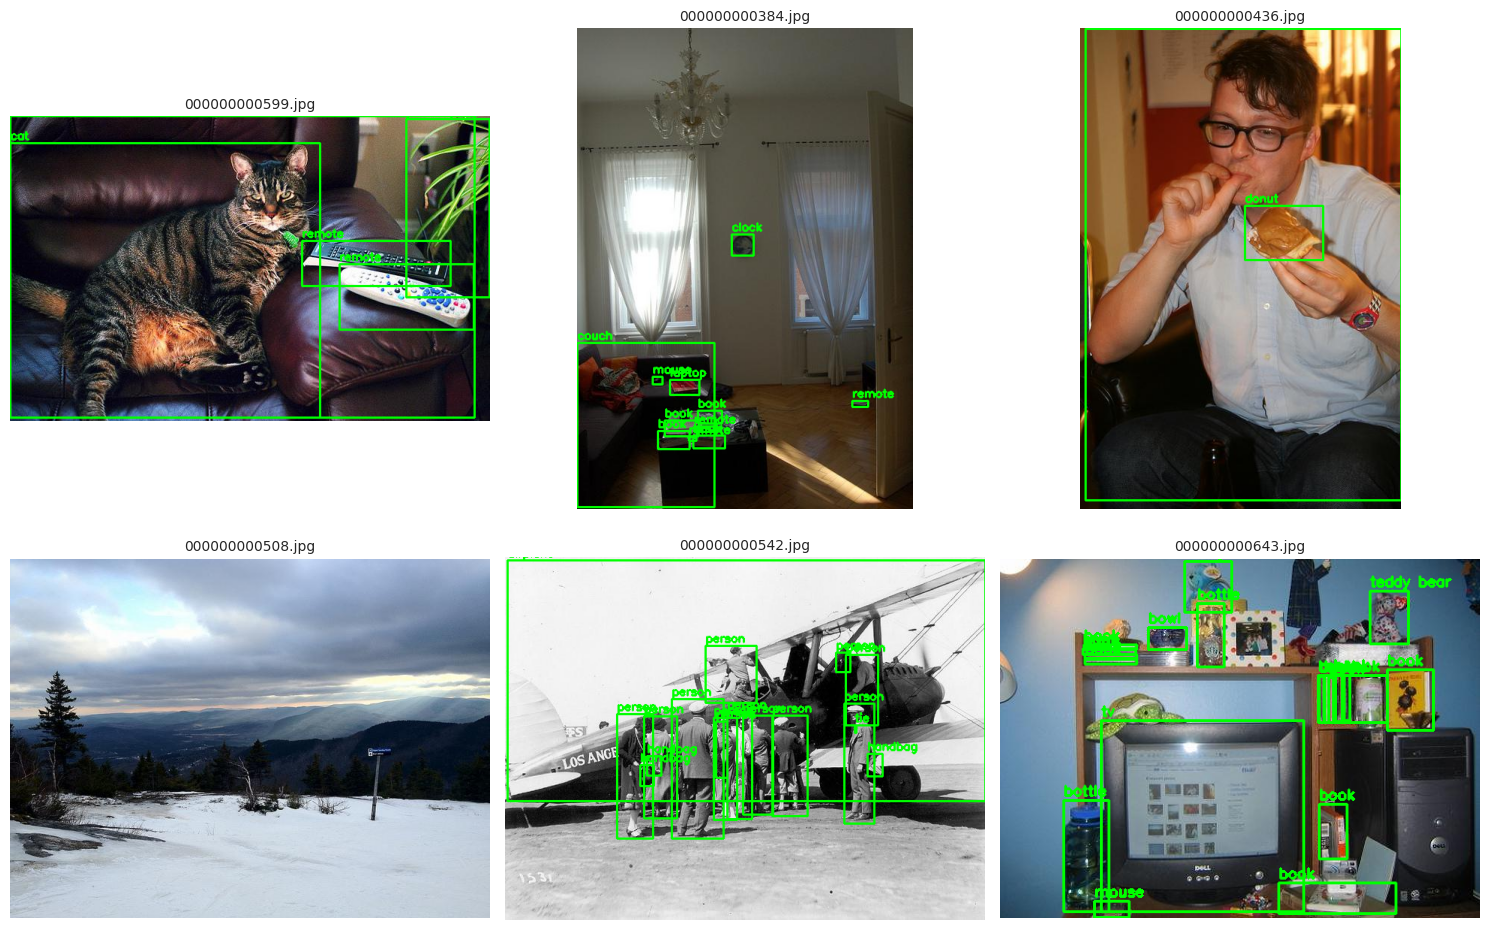

In [11]:
# Mostrar 6 imágenes aleatorias con sus anotaciones
import random

sample_images = random.sample(image_files, 6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    # Cargar imagen
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Leer labels
    label_path = labels_dir / f"{img_path.stem}.txt"
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                
                # Convertir de YOLO a pixel coords
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)
                
                # Dibujar bbox
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = coco_yaml_config['names'][cls_id]
                cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 
                           0.5, (0, 255, 0), 2)
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(img_path.name, fontsize=10)

plt.tight_layout()
plt.show()

## Guardar estadísticas para referencia

In [12]:
# Crear DataFrame con estadísticas
stats_data = []
for cls_id in sorted(class_counts.keys()):
    stats_data.append({
        'class_id': cls_id,
        'class_name': coco_yaml_config['names'][cls_id],
        'count': class_counts[cls_id],
        'percentage': class_percentages[cls_id]
    })

df_stats = pd.DataFrame(stats_data)
df_stats = df_stats.sort_values('count', ascending=False)

# Guardar a CSV
stats_path = BASE_DIR / "coco128_class_stats.csv"
df_stats.to_csv(stats_path, index=False)
print(f"\n✓ Estadísticas guardadas en: {stats_path}")

# Mostrar preview
print("\nPreview:")
print(df_stats.head(10))


✓ Estadísticas guardadas en: product_recognition/coco128_class_stats.csv

Preview:
    class_id  class_name  count  percentage
0          0      person    261   27.736451
2          2         car     48    5.100956
36        41         cup     36    3.825717
50        56       chair     35    3.719447
65        73        book     29    3.081828
40        45        bowl     28    2.975558
45        51      carrot     24    2.550478
39        44       spoon     22    2.337938
69        77  teddy bear     21    2.231668
22        26     handbag     20    2.125399


## Resumen del EDA

**Dataset:** COCO128 (subset de COCO para pruebas rápidas)

**Características identificadas:**
- Total de imágenes y labels
- Distribución de clases (algunas muy desbalanceadas)
- Número promedio de objetos por imagen
- Clases sub-representadas que podrían necesitar augmentation

**Siguiente paso:** Entrenamiento con MLflow logging → `03_training_mlflow.ipynb`